## HRV visualization for SD v1.4

In [1]:
import numpy as np
import pandas as pd
import csv
import ast
import matplotlib.pyplot as plt
import os

### Specify prompt type and concept-words

In [2]:
prompt_type = "merged"
description = "340_final_text_descriptions"
description_file_path = os.path.join(os.path.dirname(os.getcwd()), f"descriptions/{description.replace("descriptions", "list")}.csv")

### Define functions and parameters

In [4]:
data = []
with open(description_file_path, "r") as f:
    render = csv.reader(f)
    for row in render:
        data.append(row)
num_list = np.arange(1, 11).astype(str)
data = [row for row in data if row != []]
data = [row[0] for row in data if not any(num in row[0] for num in num_list)]
data[0] = data[0].replace("\ufeff","")

CONCEPTS = data

def extract_head_list(concept=None, file_path=None):
    """Extract heads from the given concept in the given files"""
    if concept not in CONCEPTS:
        raise ValueError(f"Invalid concept: {concept}")
    
    related_heads = []
    df = pd.read_csv(file_path)
    concepts = df[df.columns[0]].values
    positions = df[df.columns[1]].values

    for concept_idx, concept_name in enumerate(concepts):
        if concept == concept_name:
            related_heads += ast.literal_eval(positions[concept_idx].replace("' '", "', '").replace("\n", ","))

    for idx, related_head in enumerate(related_heads):
        a, b, c = related_head.split(",")
        related_heads[idx] = (a, int(b.replace("layer: ","")), int(c.replace("head: ","")))

    final_heads = related_heads
    
    return final_heads

print(CONCEPTS)

ranking_file_path = os.path.join(os.path.dirname(os.getcwd()), f"final_result/{description.replace("_text_descriptions", "")}_ranking_list.npy")

ranking_list = np.load(ranking_file_path)

concept_names = []
with open(description_file_path, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        concept_names.append(row)

num_list = np.arange(1, 11).astype(str)
concept_names = [row for row in concept_names if row != []]
concept_names = [row[0] for row in concept_names if not any(num in row[0] for num in num_list)]
concept_names[0] = concept_names[0][1:]
concept_names = np.array(concept_names)

['Animals', 'Plants', 'Fruits and Vegetables', 'People', 'Vehicles', 'Buildings', 'Furniture', 'Electronics', 'Clothing', 'Accessories', 'Tools', 'Toys', 'Food and Beverages', 'Books and Documents', 'Sports Equipment', 'Musical Instruments', 'Written Characters', 'Color', 'Shape', 'Texture', 'Size', 'Counting', 'Image Style', 'Material', 'Lighting Conditions', 'Facial Expressions', 'Facial Features', 'Poses and Gestures', 'Nature Scenes', 'Weather Conditions', 'Time of Day', 'Geo-locations', 'Brand Logos', 'Geometric Patterns']


### Visualize HRVs for SD v1.4

['Color' 'Animals' 'Plants' 'Fruits and Vegetables' 'People' 'Vehicles'
 'Buildings' 'Furniture' 'Electronics' 'Clothing' 'Accessories' 'Tools'
 'Toys' 'Food and Beverages' 'Books and Documents' 'Sports Equipment'
 'Musical Instruments' 'Written Characters' 'Shape' 'Texture' 'Size'
 'Counting' 'Image Style' 'Material' 'Lighting Conditions'
 'Facial Expressions' 'Facial Features' 'Poses and Gestures'
 'Nature Scenes' 'Weather Conditions' 'Time of Day' 'Geo-locations'
 'Brand Logos' 'Geometric Patterns']


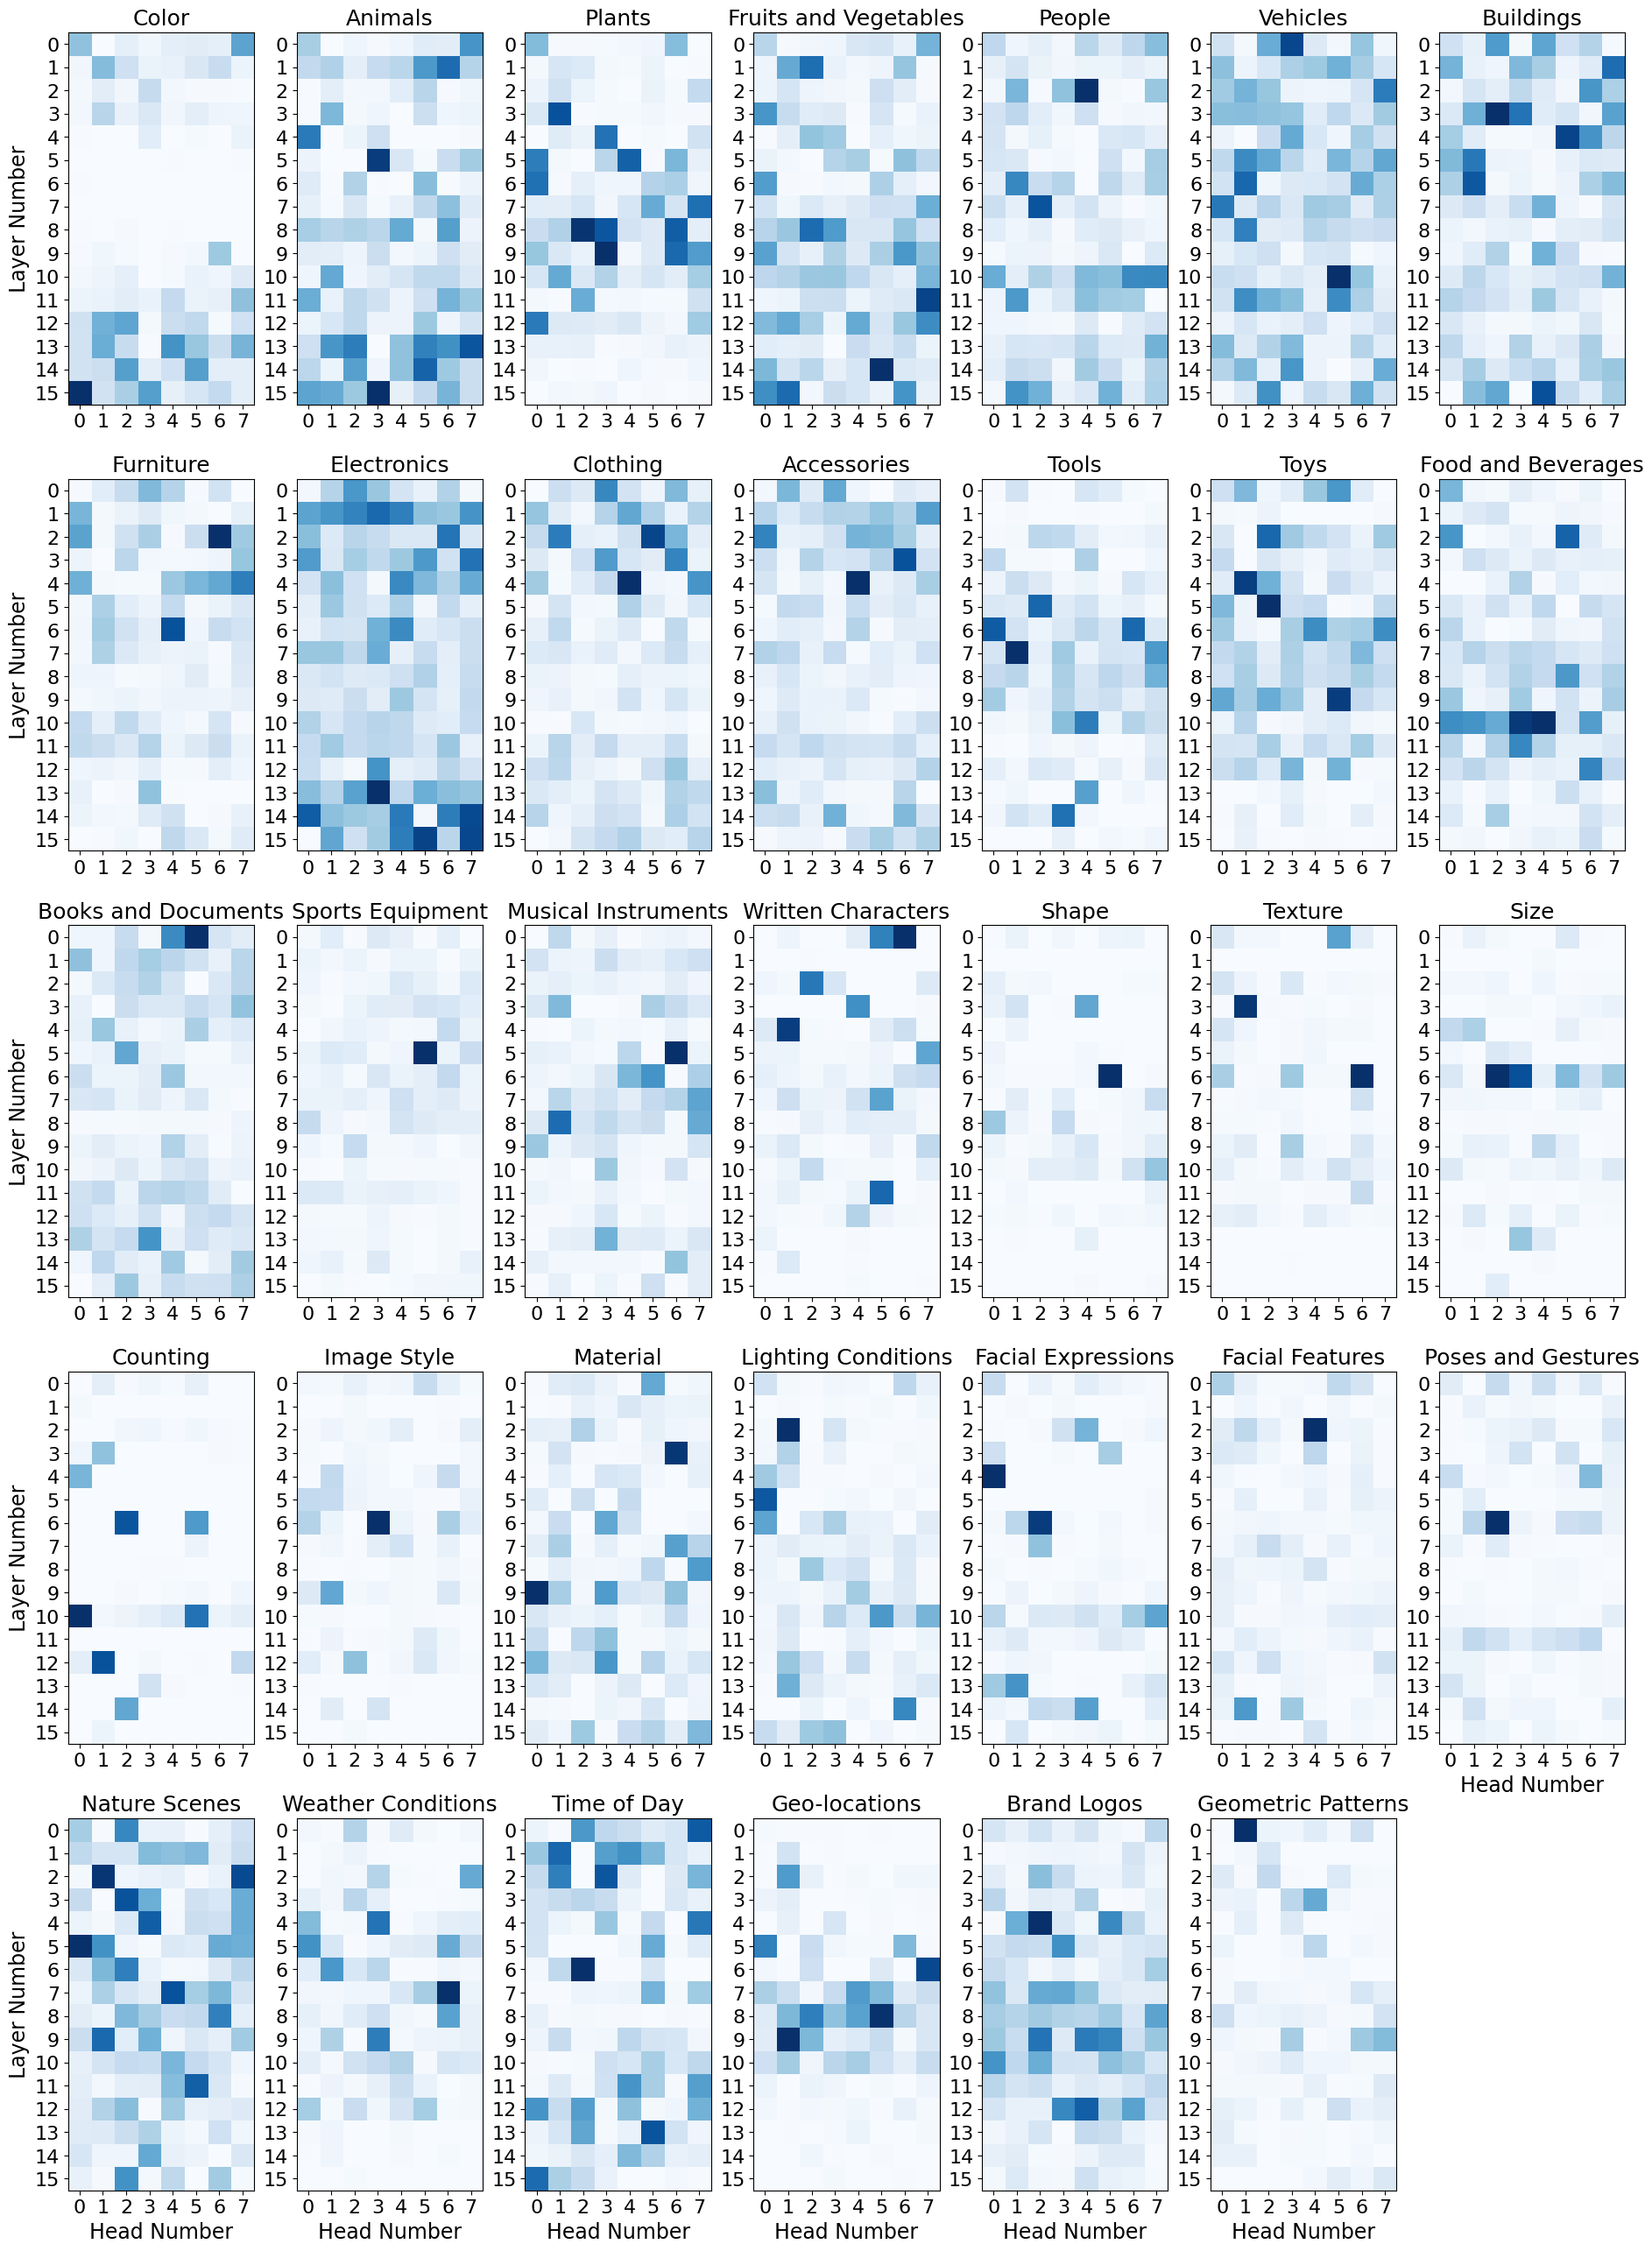

In [5]:
# -- Change the order of the concepts (move Color to the first) -- #
tmp = concept_names[17].copy()
concept_names[1:18] = concept_names[:17].copy()
concept_names[0] = tmp
tmp = ranking_list[17].copy()
ranking_list[1:18] = ranking_list[:17].copy()
ranking_list[0] = tmp
print(concept_names)
# ----------------------------------------------------------------- #

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(23, 32))
global_max = max(max(ranking) for ranking in ranking_list)
normalize = True

for i, ax in enumerate(axes.flatten()):
    if i < len(ranking_list):
        ranking = ranking_list[i]
        
        grid = np.zeros((16, 8))

        for idx, value in enumerate(ranking):
            row = idx // 8
            col = idx % 8
            grid[row, col] = value

        if normalize:
            ax.imshow(grid, cmap='Blues', interpolation='nearest')
        else:
            ax.imshow(grid, cmap='Blues', interpolation='nearest', vmin=0, vmax=global_max)
        ax.set_xticks(np.arange(-1, 7) + 1)
        ax.set_yticks(np.arange(-1, 15) + 1)
        ax.set_xticklabels([f'{label}' for label in np.arange(-1, 7) + 1], fontsize=16)
        ax.set_yticklabels([f'{label}' for label in np.arange(-1, 15) + 1], fontsize=16)

        if i >= 27:
            ax.set_xlabel('Head Number', fontsize=17)
        if i % 7 == 0:
            ax.set_ylabel('Layer Number', fontsize=17)
        ax.set_title(concept_names[i], fontsize=18)
    else:
        ax.axis('off')

# fig.suptitle('Visualization of 34 HRVs', fontsize=28)

plt.show()

### Pairwise cosine similarities between 34 HRVs

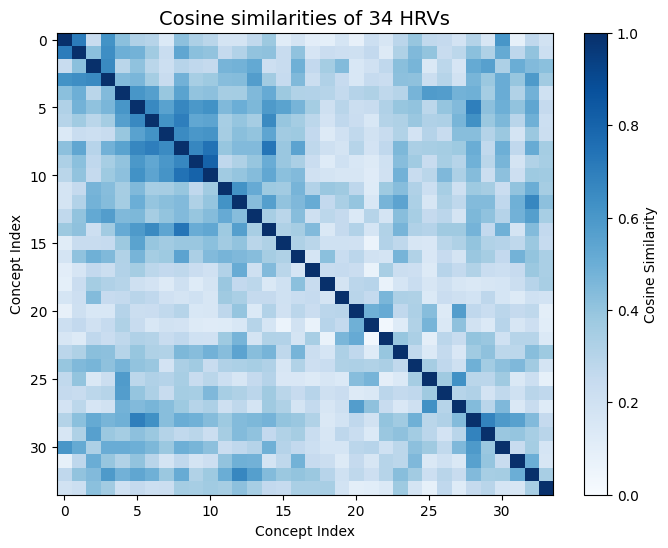

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
concept_vectors = np.load(os.path.join(os.path.dirname(os.getcwd()), f"./final_result/category_vectors_epoch_1_to_1_neg_prompt_False_{prompt_type}_{description}_sd_v1_4.npy"))
num_concepts = 34

# -- Change the order of the concepts (move Color to the first) --- #
tmp = concept_vectors[17].copy()
concept_vectors[1:18] = concept_vectors[:17].copy()
concept_vectors[0] = tmp
# ----------------------------------------------------------------- #

result = []
for i in range(num_concepts):
    vector1 = torch.tensor(concept_vectors[i]).unsqueeze(0)
    vector2 = torch.tensor(concept_vectors)
    result.append(torch.nn.functional.cosine_similarity(vector1, vector2))
result = torch.stack(result)
result = result.squeeze()

# Convert result to numpy array for plotting
result_np = result.numpy()

# Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(result_np, cmap='Blues', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine similarities of 34 HRVs', fontsize=14)
plt.xlabel('Concept Index')
plt.ylabel('Concept Index')
plt.show()

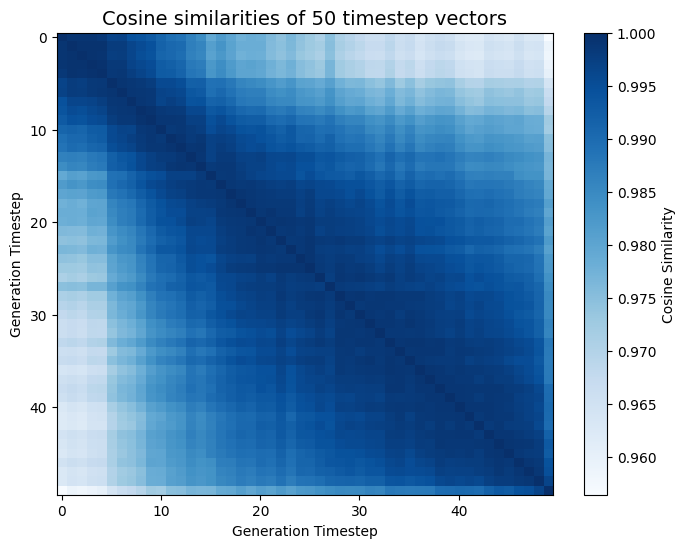

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
concept_vectors = np.load(os.path.join(os.path.dirname(os.getcwd()), f"./final_result/category_vectors_epoch_1_to_1_neg_prompt_False_{prompt_type}_{description}_sd_v1_4_per_timesteps.npy"))
num_timesteps = 50
averaged_concept_vectors = concept_vectors.mean(axis=1)
result = []
for i in range(num_timesteps):
    vector1 = torch.tensor(averaged_concept_vectors[i]).unsqueeze(0)
    vector2 = torch.tensor(averaged_concept_vectors[:num_timesteps])
    result.append(torch.nn.functional.cosine_similarity(vector1, vector2))
result = torch.stack(result)
result = result.squeeze()

# Convert result to numpy array for plotting
result_np = result.numpy()

# Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(result_np, cmap='Blues', aspect='auto')

plt.colorbar(label='Cosine Similarity')
plt.title('Cosine similarities of 50 timestep vectors', fontsize=14)
plt.xlabel('Generation Timestep')
plt.ylabel('Generation Timestep')
plt.show()